## Import Data

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../app'))

import pandas as pd

from data import Database

In [2]:
db = Database("monsters")
df = db.dataframe()
df.head()

,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
0,Faerie Dragon,Dragon,4,Rank 3,4d8+3,31.53,33.88,29.55,2024-03-28 14:22:54
1,Hell Hound,Demonic,1,Rank 3,1d8,5.44,10.65,6.87,2024-03-28 14:22:54
2,Kobold Knight,Devilkin,9,Rank 4,9d10,90.11,88.39,90.53,2024-03-28 14:22:54
3,Flame Elemental,Elemental,8,Rank 1,8d4,32.98,32.94,31.27,2024-03-28 14:22:54
4,Wyvern,Dragon,6,Rank 4,6d10,63.24,62.92,61.66,2024-03-28 14:22:54


## Feature Engineering & Splitting Data

In [3]:
# drop Name, Damage, and Timestamp columns
df.drop(['Name', 'Damage', 'Timestamp'], axis=1, inplace=True)
df.head()

,Type,Level,Rarity,Health,Energy,Sanity
0,Dragon,4,Rank 3,31.53,33.88,29.55
1,Demonic,1,Rank 3,5.44,10.65,6.87
2,Devilkin,9,Rank 4,90.11,88.39,90.53
3,Elemental,8,Rank 1,32.98,32.94,31.27
4,Dragon,6,Rank 4,63.24,62.92,61.66


In [4]:
X = df.drop('Rarity', axis=1)
y = df['Rarity']

In [5]:
X = pd.get_dummies(X)
X.head()

,Level,Health,Energy,Sanity,Type_Demonic,Type_Devilkin,Type_Dragon,Type_Elemental,Type_Fey,Type_Undead
0,4,31.53,33.88,29.55,False,False,True,False,False,False
1,1,5.44,10.65,6.87,True,False,False,False,False,False
2,9,90.11,88.39,90.53,False,True,False,False,False,False
3,8,32.98,32.94,31.27,False,False,False,True,False,False
4,6,63.24,62.92,61.66,False,False,True,False,False,False


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Establish Baseline

In [8]:
from sklearn.dummy import DummyClassifier

In [9]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train)
print("Training Accuracy: {:.2f}".format(dummy_model.score(X_train, y_train)))
print("Test Accuracy: {:.2f}".format(dummy_model.score(X_test, y_test)))

Training Accuracy: 0.29
Test Accuracy: 0.32


## Model 1: Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("Training Accuracy: {:.2f}".format(rf_model.score(X_train, y_train)))
print("Test Accuracy: {:.2f}".format(rf_model.score(X_test, y_test)))

Training Accuracy: 1.00
Test Accuracy: 0.88


### Tuning Random Forest

In [12]:
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    'n_estimators': range(25, 125, 5),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': range(5, 40, 5),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model_random = RandomizedSearchCV(
    rf_model, 
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=None,
    verbose=1,
    random_state=42,
    n_jobs=-1)

rf_model_random.fit(X_train, y_train)

print(rf_model_random.best_params_)
print("Test Accuracy: {:.2f}".format(rf_model_random.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 15, 'bootstrap': False}
Test Accuracy: 0.91


## Model 2: Gradient Boosting

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

In [14]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
print("Training Accuracy: {:.2f}".format(gb_model.score(X_train, y_train)))
print("Test Accuracy: {:.2f}".format(gb_model.score(X_test, y_test)))

Training Accuracy: 1.00
Test Accuracy: 0.89


### Tuning Gradient Boosting

In [15]:
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 'sqrt', 'log2'],
    'subsample': [0.6, 0.8, 1.0]
}

gb_model_random = RandomizedSearchCV(
    gb_model, 
    param_distributions=gb_param_grid,
    n_iter=10,
    cv=None,
    verbose=1,
    random_state=42,
    n_jobs=-1)

gb_model_random.fit(X_train, y_train)

print(gb_model_random.best_params_)
print("Test Accuracy: {:.2f}".format(gb_model_random.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.1}
Test Accuracy: 0.93


## Model 3: Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
print("Training Accuracy: {:.2f}".format(lr_model.score(X_train, y_train)))
print("Test Accuracy: {:.2f}".format(lr_model.score(X_test, y_test)))

Training Accuracy: 0.98
Test Accuracy: 0.95


/home/anthony/Clones/pyenv/versions/Bandersnatch/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Tuning Logistic Regression

In [20]:
import numpy as np

lr_param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
}

lr_model_random = RandomizedSearchCV(
    lr_model, 
    param_distributions=lr_param_grid,
    n_iter=10,
    cv=None,
    verbose=1,
    random_state=42,
    n_jobs=-1)

lr_model_random.fit(X_train, y_train)

print(lr_model_random.best_params_)
print("Test Accuracy: {:.2f}".format(lr_model_random.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'penalty': 'l2', 'C': 29.763514416313132}
Test Accuracy: 0.98


/home/anthony/Clones/pyenv/versions/Bandersnatch/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/anthony/Clones/pyenv/versions/Bandersnatch/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

## Best Model Evaluation: Logistic Regression

Accuracy: 0.96


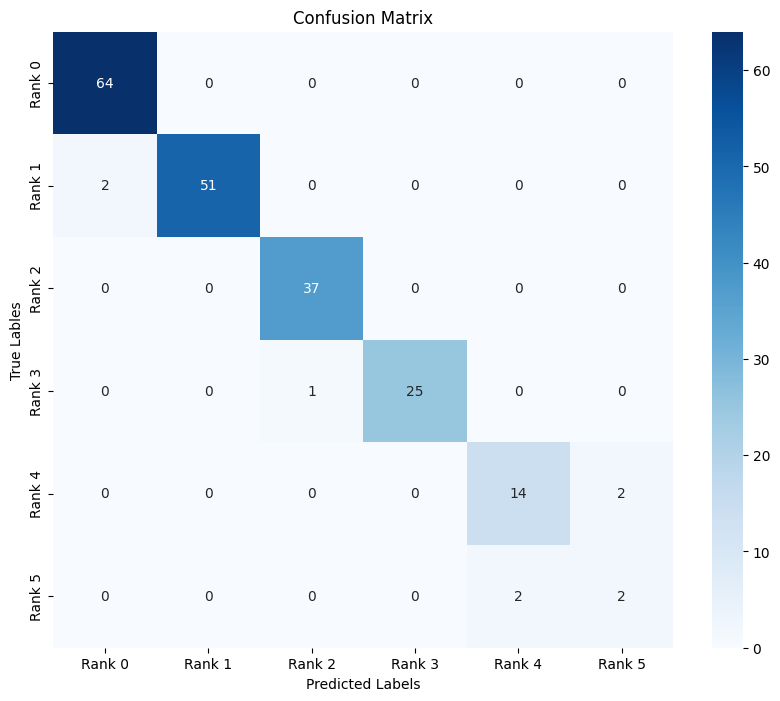

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

best_model = lr_model_random.best_estimator_
pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, pred)
class_labels = best_model.classes_
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Lables')


print("Accuracy: {:.2f}".format(accuracy_score(y_test, pred)))
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      Rank 0       0.97      1.00      0.98        64
      Rank 1       1.00      0.96      0.98        53
      Rank 2       0.97      1.00      0.99        37
      Rank 3       1.00      0.96      0.98        26
      Rank 4       0.88      0.88      0.88        16
      Rank 5       0.50      0.50      0.50         4

    accuracy                           0.96       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.97      0.96      0.96       200



## Conclusion

The Logistic Regression model performs very well when predicting Ranks 0 through 3, but begins to drop in accuracy for Rank 4 and Rank 5. An f1-score of .88 for Rank 4 is still acceptable, but a .50 f1-score for Rank 5 indicates the model struggles with predicting Monsters with higher ranks. The sample size for Rank 5 is significantly lower than the rest of the ranks which suggests more data is needed for further testing. Based on the results, the model demonstrates strong predictive power, but attention is needed for underperforming classes. Areas of improvement could include cross-validation and feature engineering focused on higher ranks.